In [1]:
%load_ext autoreload
%autoreload 2
import glob, json 
import polars as pl
import helper

# Loading data

In [66]:
patents = helper.read_json_files(glob.glob("/home/msalvetti/llm_classification/patents_output/results_oai/*.jsonl"))
websites = helper.read_json_files(glob.glob("/home/msalvetti/llm_classification/companies_patents/results_oai/*.jsonl"))

In [67]:
df = patents.join(websites, on = "ID", suffix="_website")

In [69]:
import polars as pl
from sklearn.metrics import precision_recall_fscore_support, jaccard_score

# Make set columns for easy compare
df = df.with_columns([
    pl.col('fields').list.unique().alias('truth_set'),  # patents as truth
    pl.col('fields_website').list.unique().alias('pred_set')  # website as pred
]).with_columns(
    pl.when(pl.col("truth_set").list.len()>0).then(pl.col("truth_set")).otherwise(pl.lit(["None"])),
    pl.when(pl.col("pred_set").list.len()>0).then(pl.col("pred_set")).otherwise(pl.lit(["None"]))
)
df = df.select("truth_set", "pred_set", "ID").explode("pred_set").filter(pl.col("pred_set").is_in(categories)).group_by("ID").agg(pl.col("pred_set"),pl.col("truth_set").first())

# Per-row Jaccard (overlap)
df = df.with_columns(
    (pl.struct(['truth_set', 'pred_set']).map_elements(
        lambda s: float(len(set(s['truth_set']) & set(s['pred_set'])) / len(set(s['truth_set']) | set(s['pred_set']))) 
                  if len(set(s['truth_set']) | set(s['pred_set'])) > 0 
                  else 0.0,
        return_dtype=pl.Float64,
    )).alias('jaccard'))

mean_jaccard = df['jaccard'].mean()
print(f"Mean Jaccard: {mean_jaccard}")

# Overall metrics: flatten all labels
all_truth = [label for row in df['truth_set'] for label in row]
all_pred = [label for row in df['pred_set'] for label in row]

unique_labels = list(set(all_truth + all_pred))

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=unique_labels)
truth_bin = mlb.fit_transform(df['truth_set'])
pred_bin = mlb.transform(df['pred_set'])

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(truth_bin, pred_bin, average='micro')

print(f"Micro: P={precision_micro:.2f}, R={recall_micro:.2f}, F1={f1_micro:.2f}")

overall_jaccard = jaccard_score(truth_bin, pred_bin, average='micro')
print(f"Overall Jaccard: {overall_jaccard:.2f}")

Mean Jaccard: 0.22573489648941988
Micro: P=0.23, R=0.35, F1=0.28
Overall Jaccard: 0.16


In [192]:
ict = [
    "Advanced optical communication",
    "Advanced radiofrequency communication",
    "Advanced undersea wireless communication",
    "Cloud and edge computing",
    "Digital twins",
    "Distributed ledgers",
    "Extended reality",
    "High performance computing",
    "Mesh and infrastructure independent networks",
    "Protective cyber security technologies",
]
manufacturing = [
    "Additive manufacturing",
    "Advanced composite materials",
    "Advanced explosives and energetic materials",
    "Advanced magnets and superconductors",
    "Advanced protection",
    "Coatings",
    "Continuous flow chemical synthesis",
    "Critical minerals extraction and processing",
    "High-specification machining processes",
    "Nanoscale materials and manufacturing",
    "Novel metamaterials",
    "Smart materials",
    "Wide and ultrawide bandgap semiconductors",
]
ai = [
    "Advanced data analytics",
    "Advanced integrated circuit design and fabrication",
    "Adversarial AI",
    "AI algorithms and hardware accelerators",
    "Computer vision",
    "Generative AI",
    "Machine learning",
    "Natural language processing",
]
biotech = [
    "Biological manufacturing",
    "Brain-computer interfaces",
    "Genetic engineering",
    "Genomic sequencing and analysis",
    "Neuroprosthetics",
    "Novel antibiotics and antivirals",
    "Nuclear medicine and radiation therapy",
    "Synthetic biology",
    "Vaccines and medical countermeasures",
]
defence_robotics = [
    "Advanced aircraft engines",
    "Advanced robotics",
    "Autonomous systems operation technologies",
    "Drones, swarming and collaborative robots",
    "Hypersonic detection and tracking",
    "Small satellites",
    "Space launch systems",
]
energy_env = [
    "Biofuels",
    "Directed energy technologies",
    "Electric batteries",
    "Geoengineering",
    "Grid integration technologies",
    "Hydrogen and ammonia for power",
    "Nuclear energy",
    "Nuclear waste management and recycling",
    "Photovoltaics",
    "Supercapacitors",
]
quantum = [
    "Post-quantum cryptography",
    "Quantum communication",
    "Quantum computing",
    "Quantum sensors",
]
sensing_timing_navigation = [
    "Atomic clocks",
    "Gravitational-force sensors",
    "Inertial navigation systems",
    "Magnetic field sensors",
    "Multispectral and hyperspectral imaging sensors",
    "Photonic sensors",
    "Precision agriculture",
    "Radar",
    "Satellite positioning and navigation",
    "Sonar and acoustic sensors",
]
aukus = [
    "Air-independent propulsion",
    "Autonomous underwater vehicles",
    "Electric warfare",
]
mc = [
    ict,
    manufacturing,
    ai,
    biotech,
    defence_robotics,
    energy_env,
    quantum,
    sensing_timing_navigation,
    aukus,
]

categories = []
for cat in mc:
    for c in cat:
        categories.append(c)

In [49]:
n_categories = df.explode('fields_website')["fields_website"].drop_nulls().len()
n_invented = df.explode("fields_website").filter(~pl.col("fields_website").is_in(categories)).height
print(n_invented, n_invented/n_categories)


342 0.21673003802281368


In [ ]:
websites.explode('fields').drop_nulls().filter(~pl.col("fields").is_in(categories))

primary_field,fields,explanation,confidence,ID
str,str,str,str,str
"""Cloud and edge computing""","""Automation""","""HPH Hardegger AG is involved i…","""High""","""CHCHE103562915"""
"""Cloud and edge computing""","""ICT""","""HPH Hardegger AG is involved i…","""High""","""CHCHE103562915"""
"""Advanced protection""","""Sound and vibration damping te…","""Andair AG specializes in shelt…","""High""","""CHCHE113862856"""
"""Advanced protection""","""Ventilation components""","""Andair AG specializes in shelt…","""High""","""CHCHE113862856"""
"""Additive manufacturing""","""Advanced machining technologie…","""Suhner specializes in advanced…","""High""","""CHCHE102508942"""
…,…,…,…,…
"""Robotics""","""Textile""","""Stäubli is a global provider o…","""High""","""CHCHE107991617"""
"""Photovoltaics""","""Energy storage""","""The company focuses on solar e…","""High""","""CHCHE105535496"""
"""Advanced robotics""","""Software development""","""Tribecraft is involved in the …","""High""","""CHCHE105100603"""


/home/msalvetti/llm_classification/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:1007: UserWarning: unknown class(es) ['Adversarial AI', 'Air-independent propulsion', 'Autonomous underwater vehicles', 'Brain-computer interfaces', 'Directed energy technologies', 'Generative AI', 'Gravitational-force sensors', 'Hypersonic detection and tracking', 'Magnetic field sensors', 'Multispectral and hyperspectral imaging sensors', 'Novel metamaterials', 'Photonic sensors', 'Quantum sensors', 'Radar', 'Small satellites', 'Sonar and acoustic sensors', 'Space launch systems', 'Supercapacitors'] will be ignored
  warnings.warn(
/home/msalvetti/llm_classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


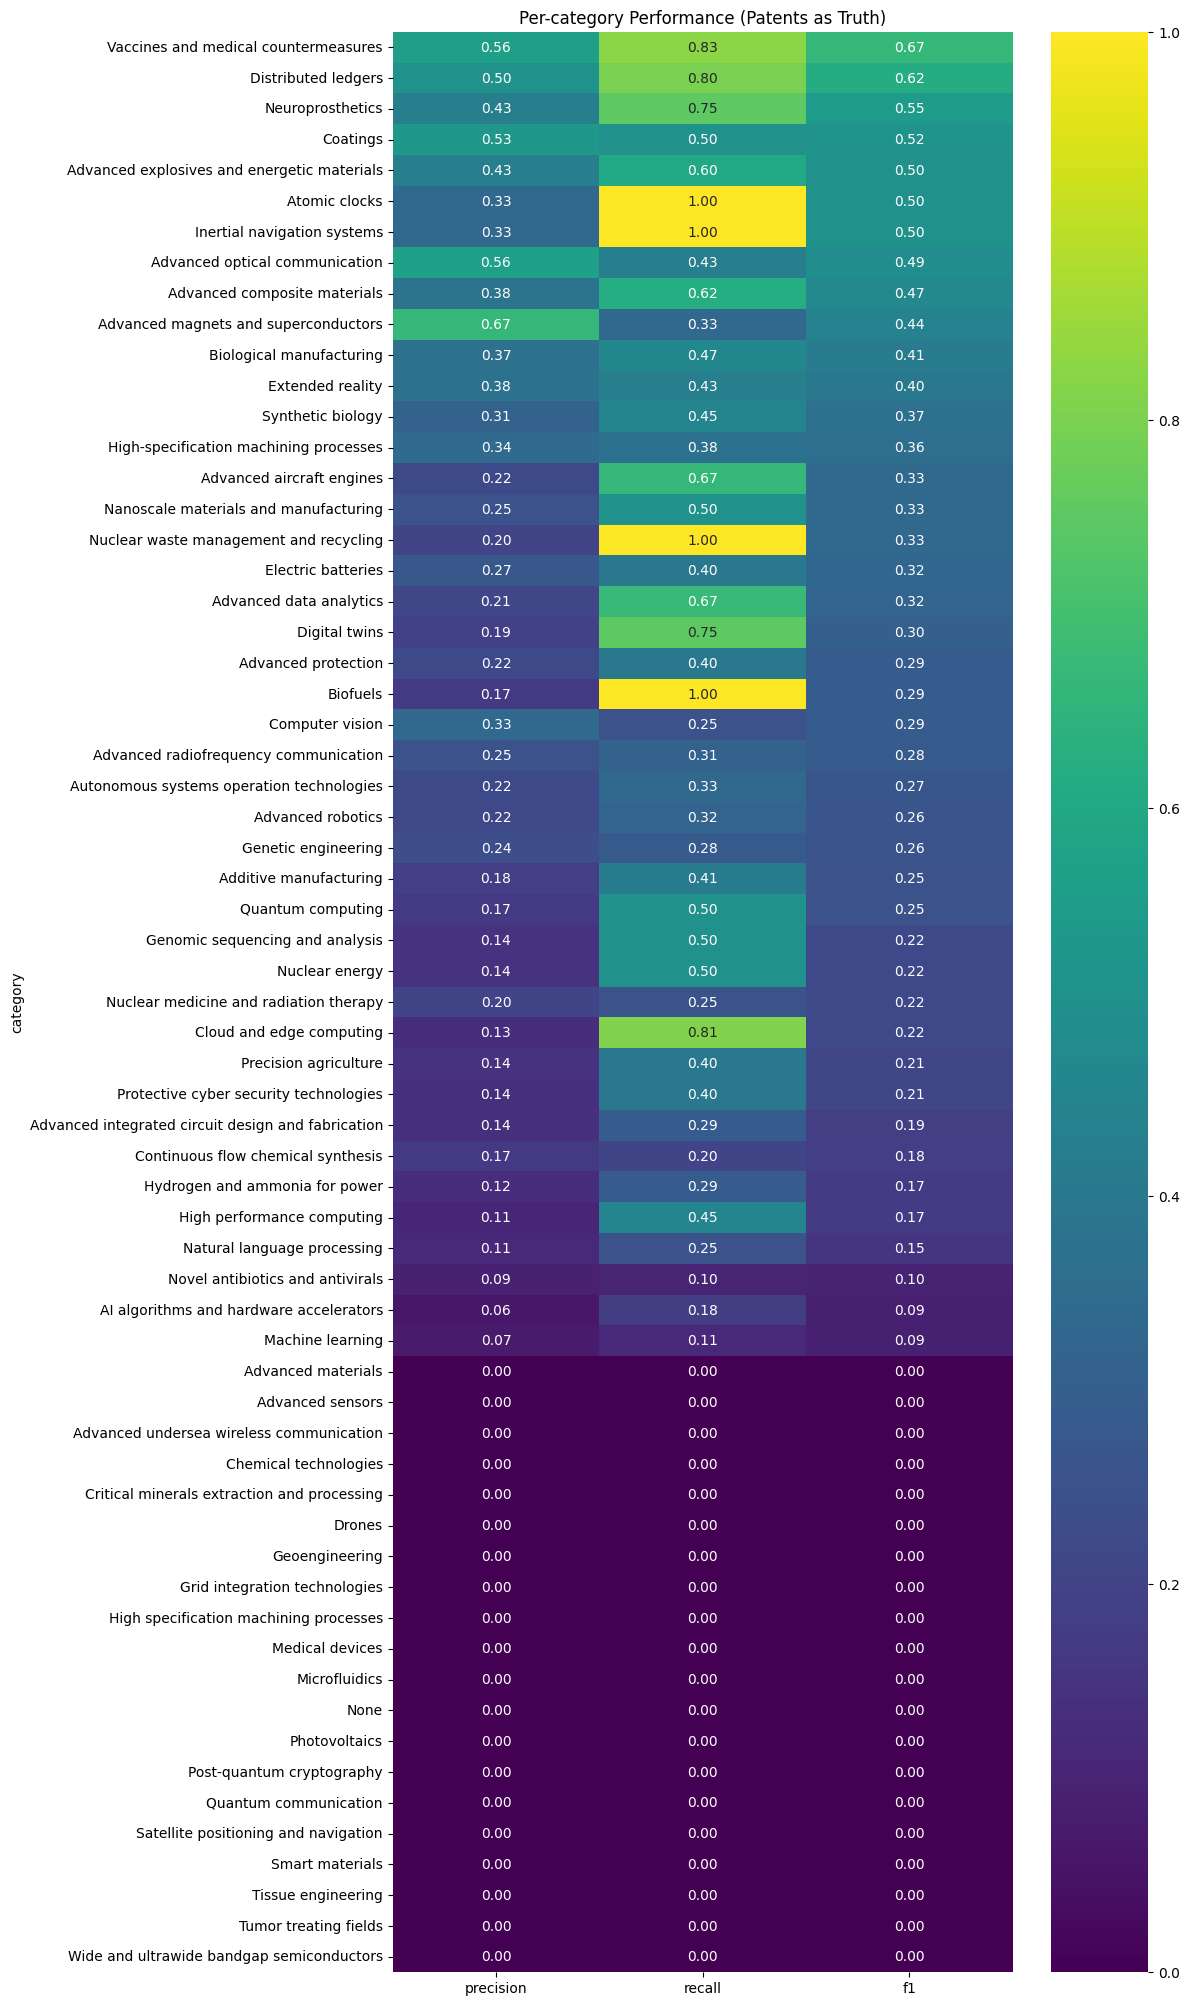

In [70]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

mlb = MultiLabelBinarizer()
truth_bin = mlb.fit_transform(df['truth_set'])
pred_bin = mlb.transform(df['pred_set'])

p, r, f1, support = precision_recall_fscore_support(truth_bin, pred_bin, average=None, labels=range(len(mlb.classes_)))

metrics_df = pl.DataFrame({
    'category': mlb.classes_,
    'precision': p,
    'recall': r,
    'f1': f1
}).sort('f1', descending=True)

# Heatmap style (or bar)
pdf_metrics = metrics_df.to_pandas().set_index('category')
plt.figure(figsize=(10, len(mlb.classes_) * 0.4))
sns.heatmap(pdf_metrics[['precision', 'recall', 'f1']], annot=True, fmt='.2f', cmap='viridis')
plt.title('Per-category Performance (Patents as Truth)')
plt.show()

In [65]:
df = df.select("truth_set", "pred_set", "ID").explode("pred_set").filter(pl.col("pred_set").is_in(categories)).group_by("ID").agg(pl.col("pred_set"),pl.col("truth_set").first())

In [101]:
counts_websites = websites.select("fields").explode("fields").filter(
    pl.col("fields").is_in(categories)
    ).fill_null("None").group_by("fields").agg(pl.len()).with_columns(
        pl.col("len")/pl.col("len").sum()
    ).sort("len", descending=True)

counts_patents = patents.select("fields").explode("fields").filter(
    pl.col("fields").is_in(categories)
    ).fill_null("None").group_by("fields").agg(pl.len()).with_columns(
        pl.col("len")/pl.col("len").sum()
).sort("len", descending=True)

In [162]:
plot = counts_patents.join(counts_websites, on = "fields", suffix = "_website").rename(
    {"len": "Patents", 
    "len_website": "Website"}
    )
plot_pivot  = plot.unpivot(index="fields").rename({"variable": "Group"})

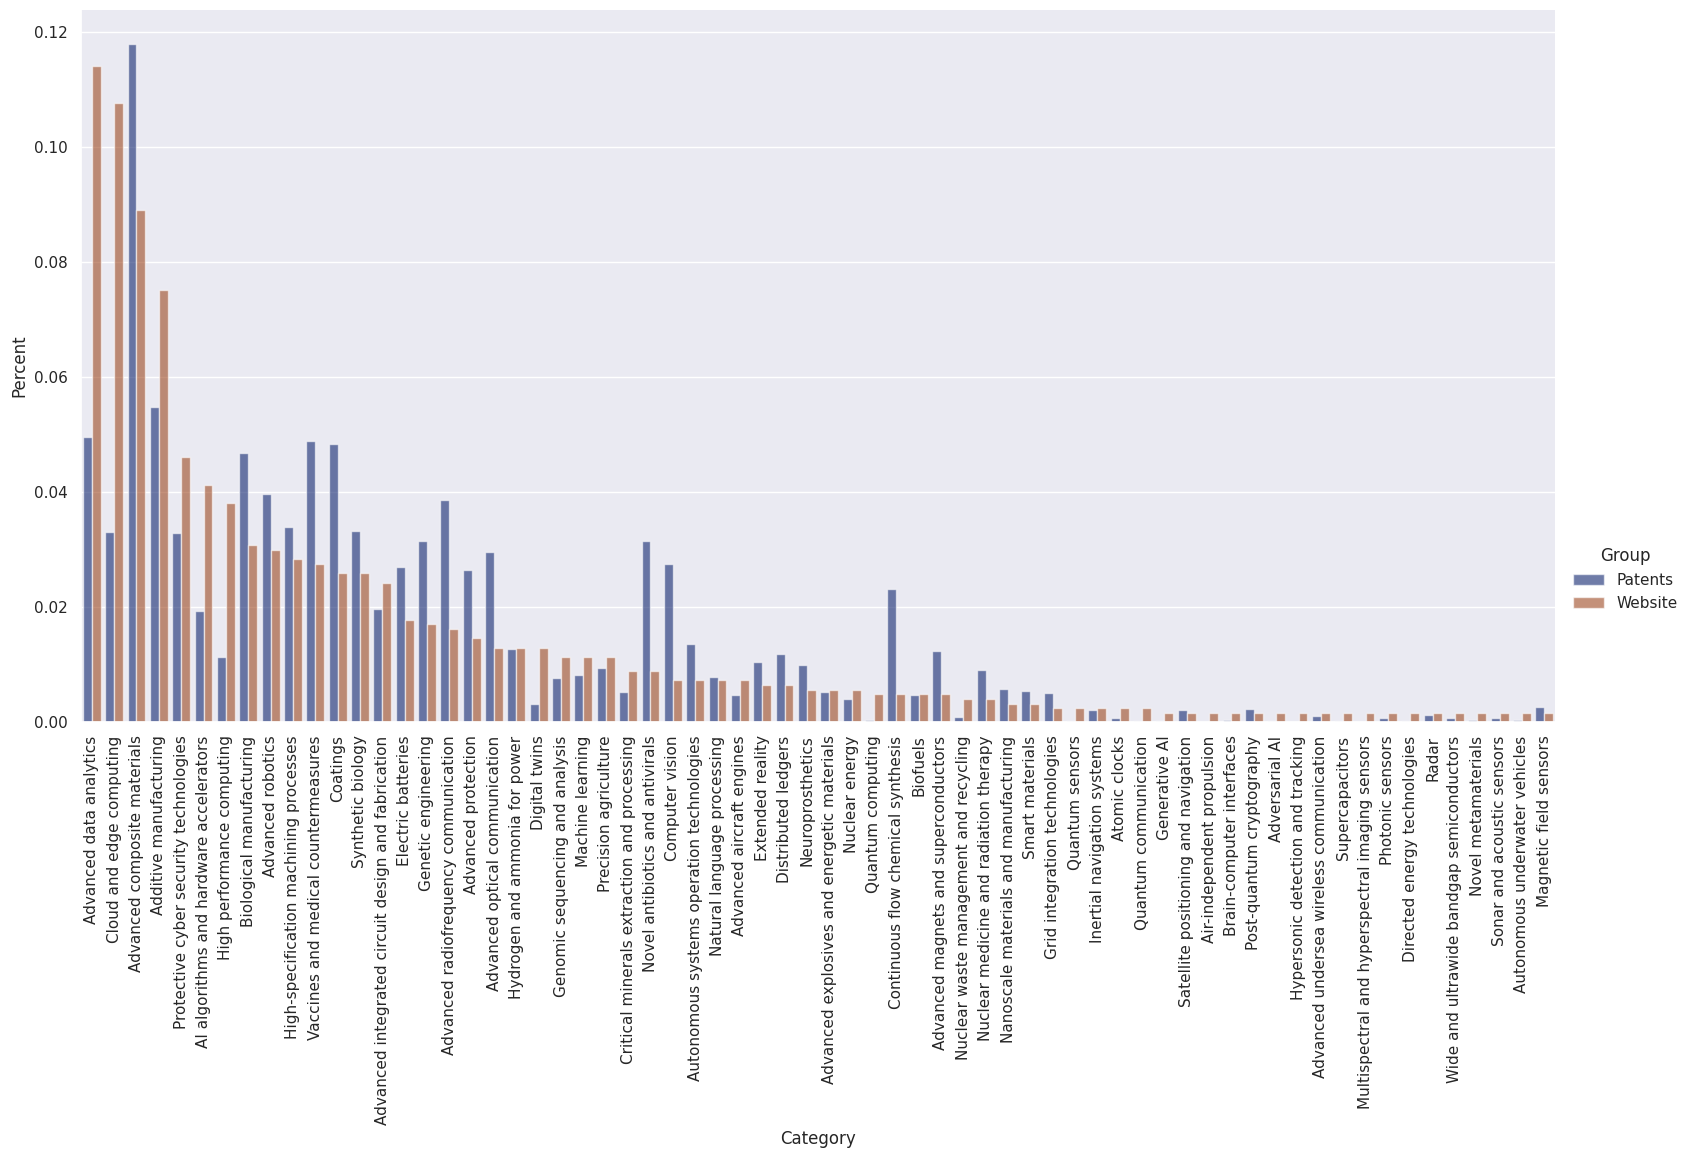

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

g = sns.catplot(x = plot_pivot["fields"], y = plot_pivot["value"], 
            hue = plot_pivot["Group"],
            kind = "bar",
            palette = "dark",
            alpha = 0.6,
            height= 8, aspect=2)
g.set_axis_labels("Category","Percent")
g.set_xticklabels(rotation = 90)

In [198]:
plot.select(pl.corr("Patents","Website"))

Patents
f64
0.717347


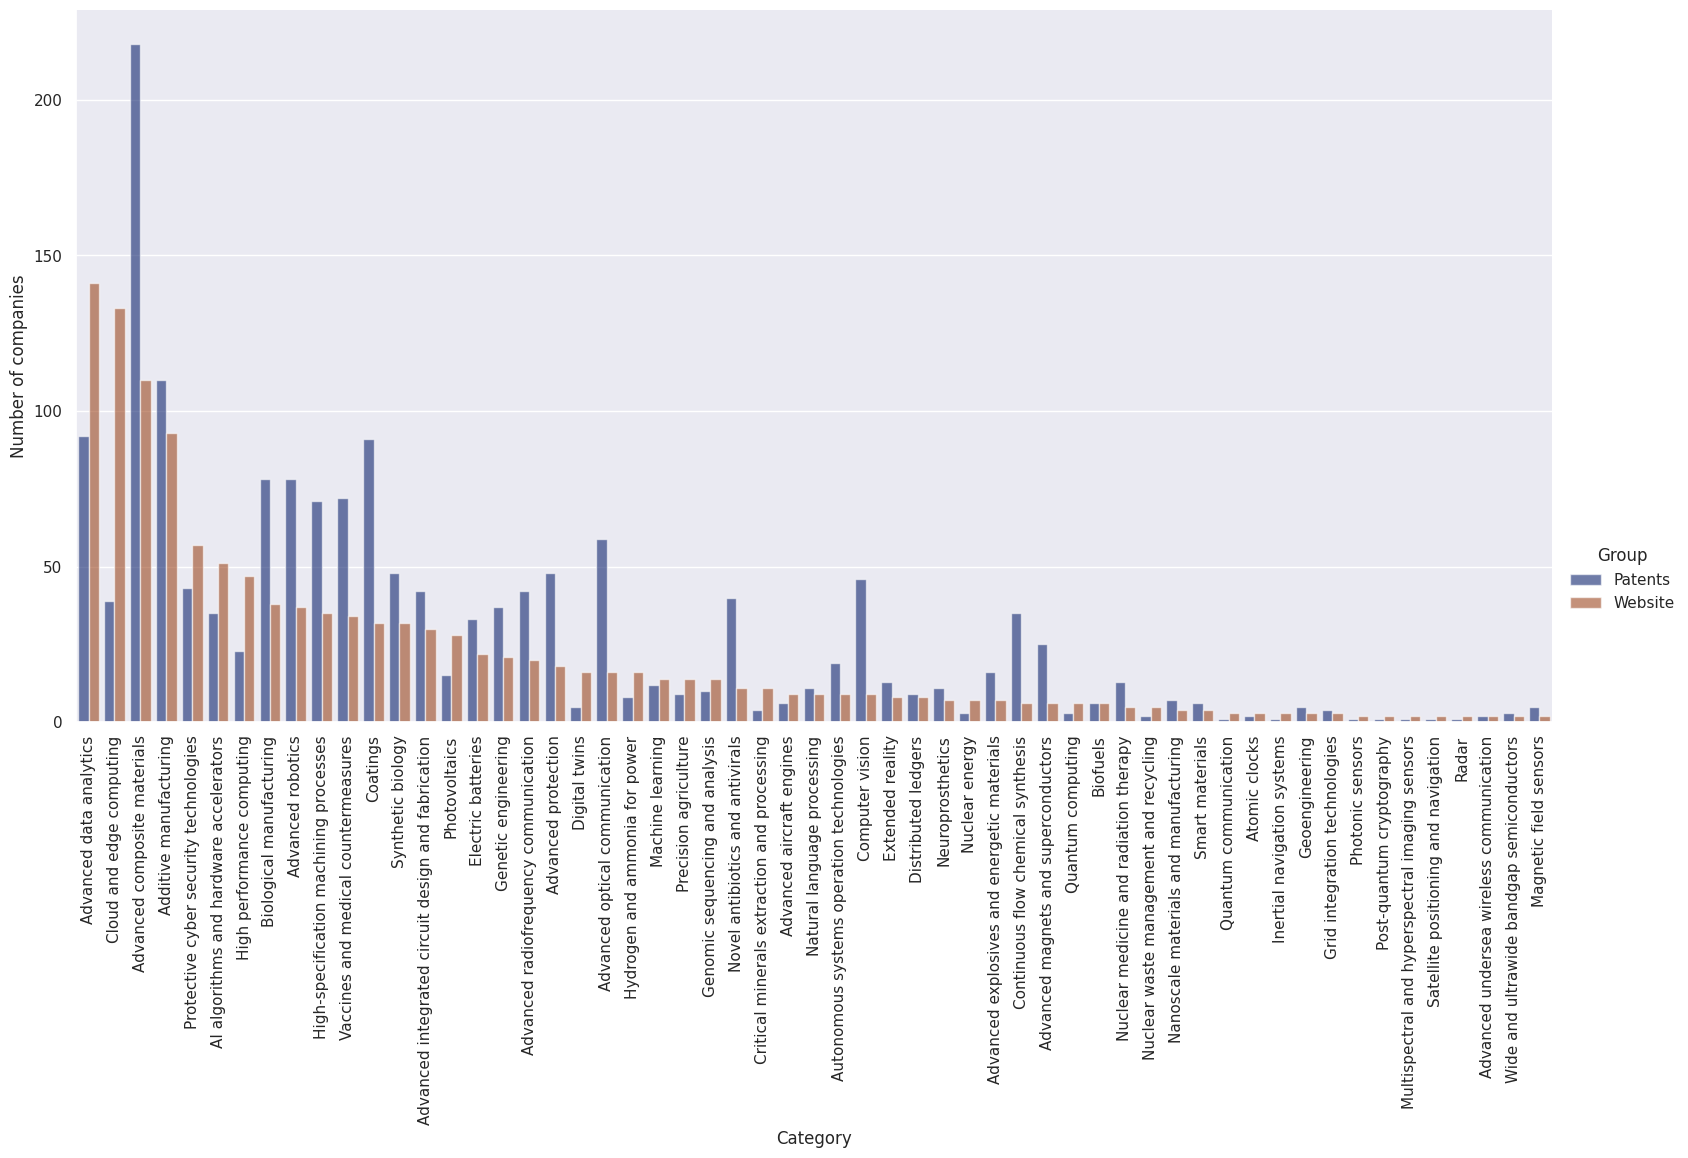

In [194]:
counts_websites = joined.select("fields_website").explode("fields_website").filter(
    pl.col("fields_website").is_in(categories)
    ).fill_null("None").group_by("fields_website").agg(pl.len()).sort("len", descending=True).rename({"fields_website": "fields"})

counts_patents = joined.select("fields").explode("fields").filter(
    pl.col("fields").is_in(categories)
    ).fill_null("None").group_by("fields").agg(pl.len()).sort("len", descending=True)

plot = counts_patents.join(counts_websites, on = "fields", suffix = "_website").rename(
    {"len": "Patents", 
    "len_website": "Website"}
    )
plot_pivot  = plot.unpivot(index="fields").rename({"variable": "Group"})

sns.set_theme(style="darkgrid")

g = sns.catplot(x = plot_pivot["fields"], y = plot_pivot["value"], 
            hue = plot_pivot["Group"],
            kind = "bar",
            palette = "dark",
            alpha = 0.6,
            height= 8, aspect=2)
g.set_axis_labels("Category","Number of companies")
g.set_xticklabels(rotation = 90)

In [204]:
w = set(websites["ID"])
p = set(patents["ID"])
len(w.intersection(p))

1916